In [1]:
import sys
sys.path.append('./scripts/')
from dp_policy_agent import *
import random, copy

In [2]:
class StateInfo:
    def __init__(self, action_num, epsilon=0.3):
        self.q = np.zeros(action_num)
        self.epsilon = epsilon
        
    def greedy(self):
        return np.argmax(self.q)
    
    def epsilon_greedy(self, epsilon): 
        if random.random() < epsilon:
            return random.choice(range(len(self.q)))
        else:
            return self.greedy()
    
    def pi(self):
        return self.epsilon_greedy(self.epsilon) 
    
    def max_q(self): 
        return max(self.q)

In [3]:
class SarsaAgent(DpPolicyAgent):  #名前をSarsaAgentに ###sarsa1
    def __init__(self, time_interval, estimator, puddle_coef=100,  alpha=0.5, widths=np.array([0.2, 0.2, math.pi/18]).T, \
                 lowerleft=np.array([-4, -4]).T, upperright=np.array([4, 4]).T, dev_borders=[0.1,0.2,0.4,0.8]): 
        super().__init__(time_interval, estimator, None, puddle_coef, widths, lowerleft, upperright)
        
        nx, ny, nt = self.index_nums
        self.indexes = list(itertools.product(range(nx), range(ny), range(nt)))
        self.actions = list(set([tuple(self.policy_data[i]) for i in self.indexes]))
        self.ss = self.set_action_value_function()
        
        ##強化学習用変数##
        self.alpha = alpha
        self.s, self.a = None, None
        self.update_end = False

    def set_action_value_function(self):
        ss = {}
        for line in open("data/puddle_ignore_values.txt", "r"):
            d = line.split()
            index, value = (int(d[0]), int(d[1]), int(d[2])), float(d[3])
            ss[index] = StateInfo(len(self.actions))
            
            for i, a in enumerate(self.actions):
                ss[index].q[i] = value if tuple(self.policy_data[index]) == a else value - 0.1
                ss[index].q[i] *= 10 #大きくしておく
                
        return ss
    
    def policy(self, pose, goal=None): 
        index = self.to_index(pose, self.pose_min, self.index_nums, self.widths)               
        s = tuple(index)
        a = self.ss[s].pi()
        return s, a
    
    def decision(self, observation=None):
        ###終了処理###
        if self.update_end:  return 0.0, 0.0
        if self.in_goal:          self.update_end = True
        
        ##カルマンフィルタの実行##
        self.estimator.motion_update(self.prev_nu, self.prev_omega, self.time_interval)
        self.estimator.observation_update(observation)
        
        ##行動決定と報酬の処理##
        s_, a_ = self.policy(self.estimator.pose)
        r = self.time_interval*self.reward_per_sec() 
        self.total_reward += r
        
        ##学習と現在の状態と行動の保存##
        self.q_update(self.s, self.a, r, s_, a_) #a_も引数に加える
        self.s, self.a = s_, a_

        ##出力##
        self.prev_nu, self.prev_omega = self.actions[a_]
        return self.actions[a_]

    def q_update(self, s, a, r, s_, a_):###sarsa1
        if s == None: return
        
        q = self.ss[s].q[a]
        q_ = self.final_value if self.in_goal else self.ss[s_].q[a_]     #max_qからQ(s_,a_)に書き換え
        self.ss[s].q[a] = (1.0 - self.alpha)*q + self.alpha*(r + q_)

In [4]:
class WarpRobot(Robot):
    def __init__(self, *args, **kwargs): 
        super().__init__(*args, **kwargs)
        
        self.init_agent = copy.deepcopy(self.agent) #エージェントのコピーを残しておく
        
    def choose_pose(self):  #初期位置をランダムに決めるメソッド
        xy = random.random()*6-2
        t = random.random()*2*math.pi
        return np.array([3, xy, t]).T if random.random() > 0.5 else np.array([xy, 3, t]).T
        
    def reset(self):
        #ssだけ残してエージェントを初期化
        tmp = self.agent.ss
        self.agent = copy.deepcopy(self.init_agent)
        self.agent.ss  = tmp
        
        #初期位置をセット（ロボット、カルマンフィルタ）
        self.pose = self.choose_pose()
        self.agent.estimator.belief = multivariate_normal(mean=self.pose, cov=np.diag([1e-10, 1e-10, 1e-10]))
        
        #軌跡の黒い線が残らないように消す
        self.poses = []
    
    def one_step(self, time_interval):
        if self.agent.update_end:
            with open("log.txt", "a") as f:
                f.write("{}\n".format(self.agent.total_reward + self.agent.final_value))
            self.reset()
            return
        
        super().one_step(time_interval)

<IPython.core.display.Javascript object>


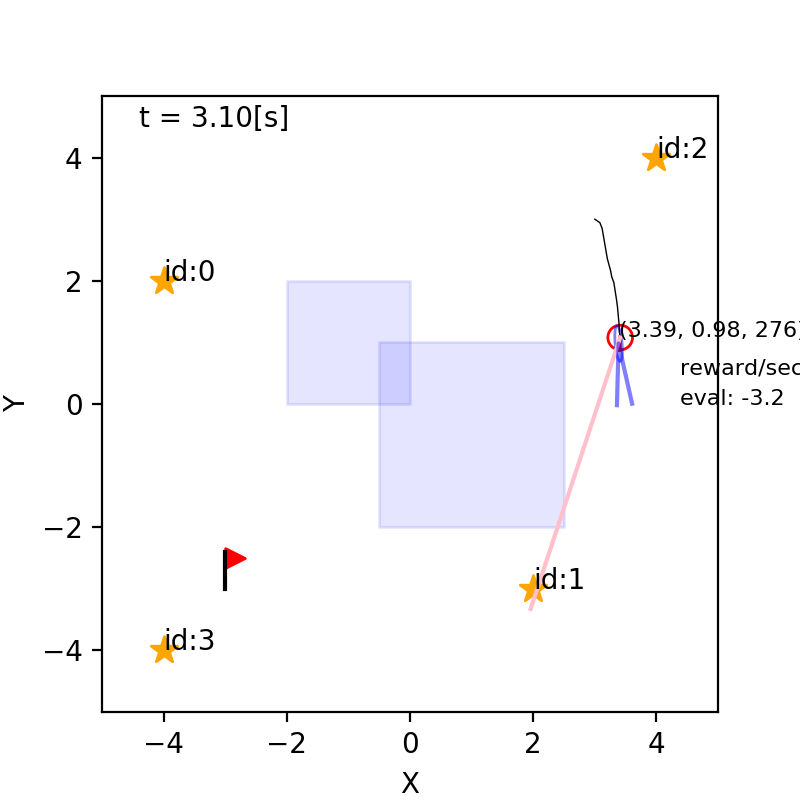

In [5]:
def trial(): 
    time_interval = 0.1
    world = PuddleWorld(400000, time_interval, debug=False)  #長時間アニメーション時間をとる

    ## 地図を生成して3つランドマークを追加 ##
    m = Map()
    for ln in [(-4,2), (2,-3), (4,4), (-4,-4)]: m.append_landmark(Landmark(*ln))
    world.append(m)   

    ##ゴールの追加##
    goal = Goal(-3,-3) 
    world.append(goal)
    
    ##水たまりの追加##
    world.append(Puddle((-2, 0), (0, 2), 0.1)) 
    world.append(Puddle((-0.5, -2), (2.5, 1), 0.1)) 

    ##ロボットを1台登場させる##
    init_pose = np.array([3, 3, 0]).T
    kf = KalmanFilter(m, init_pose)
    a = SarsaAgent(time_interval, kf)
    r = WarpRobot(init_pose, sensor=Camera(m, distance_bias_rate_stddev=0, direction_bias_stddev=0), 
              agent=a, color="red", bias_rate_stds=(0,0))
    world.append(r)
    
    world.draw()
    return a
    
a = trial()

In [6]:
def draw_policy():
    p = np.zeros(a.index_nums[0:2])
    for x in range(a.index_nums[0]):
        for y in range(a.index_nums[1]):
            act = a.ss[(x,y,22)].greedy()
            p[x,y] = a.actions[act][0] + a.actions[act][1]

    import seaborn as sns   
    sns.heatmap(np.rot90(p), square=False)
    plt.show()

In [7]:
def draw_value():
    v = np.zeros(a.index_nums[0:2])
    for x in range(a.index_nums[0]):
        for y in range(a.index_nums[1]):
            v[x,y] = a.ss[(x,y,18)].max_q()

    import seaborn as sns   
    sns.heatmap(np.rot90(v), square=False)
    plt.show()